[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/getting_started.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/docs/blob/main/tutorials/getting_started.ipynb)
# Getting Started

To get started using Qrlew, let's:
* Get access to a database.
* Install Qrlew python bindings: `pyqrlew`.
* Load a few tables.
* Connect to the database and create a `pyqrlew.Dataset`.
* Set bounds to some variables.
* Define the privacy unit
* Write a query and rewrite it as differentially private.
* Execute the DP query on the local database.

## Get access to a database

Let's start by installing a local PostgreSQL database.

In [1]:
%%capture
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'password'"
!pip install psycopg2

## Install Qrlew python bindings: `pyqrlew`

`pyqrlew` is distributed on [PyPI](https://pypi.org/project/pyqrlew/) and simply installed with `pip install`.

In [2]:
%%capture
!pip install pyqrlew

## Load a few tables

In [3]:
from pyqrlew.io import PostgreSQL

database = PostgreSQL('postgres', 'postgres', 'password', 5432)
database.load_retail()
engine = database.engine()

In [4]:
from IPython.display import display, Markdown
import pandas as pd

display(Markdown('Stores: `SELECT * FROM retail.stores LIMIT 5`'))
display(pd.read_sql('SELECT * FROM retail.stores LIMIT 5', engine))
display(Markdown('Sales: `SELECT * FROM retail.sales LIMIT 5`'))
display(pd.read_sql('SELECT * FROM retail.sales LIMIT 5', engine))
display(Markdown('Features: `SELECT * FROM retail.features LIMIT 5`'))
display(pd.read_sql('SELECT * FROM retail.features LIMIT 5', engine))

Stores: `SELECT * FROM retail.stores LIMIT 5`

,store,type,size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Sales: `SELECT * FROM retail.sales LIMIT 5`

,id,store,date,weekly_sales,isholiday
0,1,1,2010-02-05,24924.50,False
1,2,1,2010-02-12,46039.49,True
2,3,1,2010-02-19,41595.55,False
3,4,1,2010-02-26,19403.54,False
4,5,1,2010-03-05,21827.90,False


Features: `SELECT * FROM retail.features LIMIT 5`

,id,store,date,temperature,fuel_price,cpi,unemployment,isholiday
0,1,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,2,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,3,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,4,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,5,1,2010-03-05,46.50,2.625,211.350143,8.106,False


## Connect to the database and create a `pyqrlew.Dataset`

In [5]:
from pyqrlew.io.dataset import dataset

source_dataset = dataset('retail', engine, 'retail')
source_dataset.relations()

[(['retail', 'retail', 'features'], <Relation at 0x7a161a447cb0>),
 (['retail', 'retail', 'sales'], <Relation at 0x7a1619a88790>),
 (['retail', 'retail', 'stores'], <Relation at 0x7a1619a88af0>)]

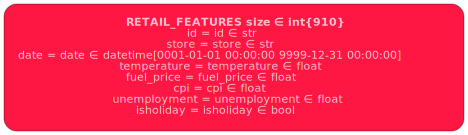

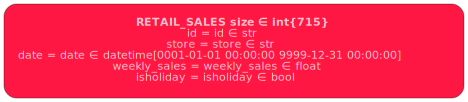

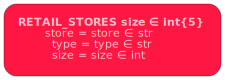

In [6]:
from graphviz import Source

for path, relation in source_dataset.relations():
  display(Source(relation.dot()))

## Set bounds to some variables

In [7]:
bounded_dataset = source_dataset.from_queries([
    (('retail', 'retail', 'features'),  'SELECT * FROM retail.features WHERE fuel_price > 2.514 AND fuel_price < 3.907'),
    (('retail', 'retail', 'sales'),  'SELECT * FROM retail.sales'),
    (('retail', 'retail', 'stores'),  'SELECT * FROM retail.stores'),
])

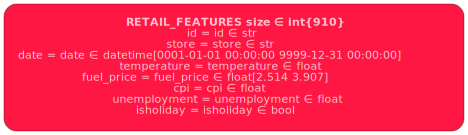

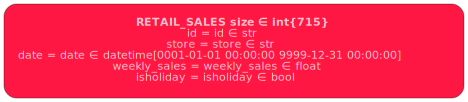

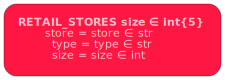

In [8]:
for path, relation in bounded_dataset.relations():
  display(Source(relation.dot()))

In [9]:
relation.render()

'SELECT * FROM retail.stores'

## Define the privacy unit

In [10]:
privacy_unit = [
    ("features", [], "id"),
    ("stores", [("store", "features", "store")], "id"),
    ("sales", [], "id")
]
# Other arguments that will be explained later
budget = {"epsilon": 1.0, "delta": 5e-4}
synthetic_data = [
    (["retail", "features"], ["retail", "features_sd"]),
]

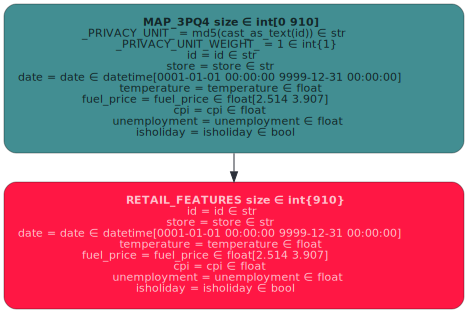

In [11]:
pup_features = bounded_dataset.relations()[0][1].rewrite_as_privacy_unit_preserving(
    bounded_dataset,
    privacy_unit,
    budget,
    synthetic_data,
)
display(Source(pup_features.relation().dot()))

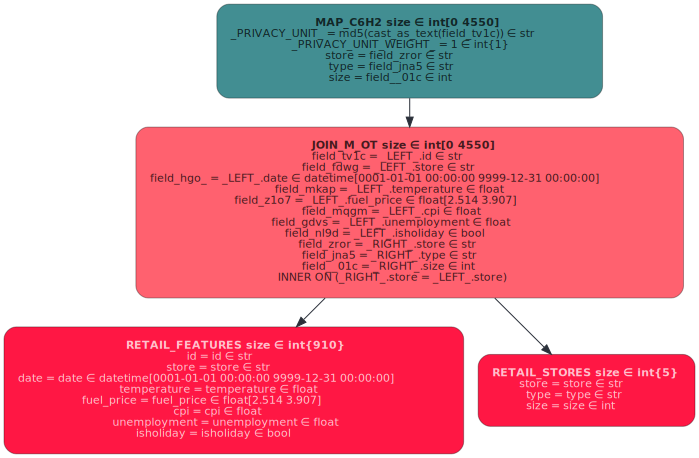

In [12]:
pup_stores = bounded_dataset.relations()[2][1].rewrite_as_privacy_unit_preserving(
    bounded_dataset,
    privacy_unit,
    budget,
    synthetic_data
)
display(Source(pup_stores.relation().dot()))

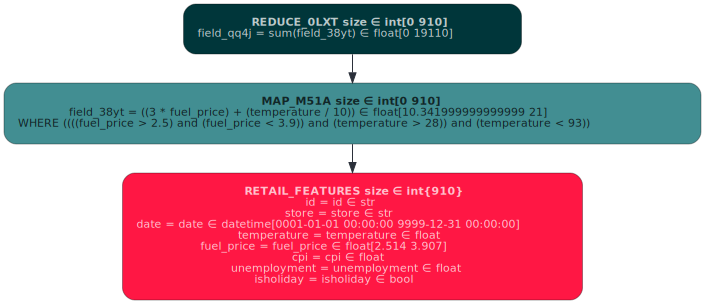

In [13]:
relation = bounded_dataset.sql('SELECT SUM(3 * fuel_price + temperature / 10) FROM retail.features WHERE fuel_price > 2.5 AND fuel_price < 3.9 AND temperature > 28 AND temperature < 93')
display(Source(relation.dot()))

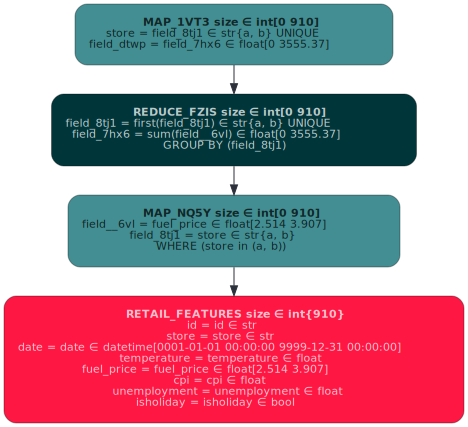

In [14]:
relation = bounded_dataset.sql("SELECT store, SUM(fuel_price) FROM retail.features WHERE store IN ('a', 'b') GROUP BY store ")
display(Source(relation.dot()))

In [15]:
privacy_unit = [
    ("stores", [("store", "features", "store")], "id"),
    ("features", [], "id"),
    ("sales", [], "id")
]
budget = {"epsilon": 1.0, "delta": 5e-4}
synthetic_data = None

query = "SELECT SUM(fuel_price) AS my_sum FROM retail.features WHERE fuel_price > 2.514 AND fuel_price < 3.907"
relation = bounded_dataset.sql(query)

relation_with_dp_event = relation.rewrite_with_differential_privacy(
    bounded_dataset,
    privacy_unit,
    budget,
    synthetic_data,
)
dp_relation = relation_with_dp_event.relation()
mechanisms_used = relation_with_dp_event.dp_event()

In [16]:
print(relation_with_dp_event)

Relation: SELECT my_sum AS my_sum FROM ( SELECT _SUM_field__6vl AS my_sum FROM ( SELECT least(3555.37, greatest(0, (coalesce(_SUM_field__6vl, 0) + (15.455181404019267 * (sqrt((-2 * ln(random()))) * cos((6.283185307179586 * random()))))))) AS _SUM_field__6vl FROM ( SELECT sum(field_q9u_) AS _SUM_field__6vl FROM ( SELECT _CLIPPED_field__6vl AS field_q9u_ FROM ( SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, field__6vl AS field__6vl, _SCALE_FACTOR__PRIVACY_UNIT_ AS _SCALE_FACTOR__PRIVACY_UNIT_, _SCALE_FACTOR_field__6vl AS _SCALE_FACTOR_field__6vl, (field__6vl * _SCALE_FACTOR_field__6vl) AS _CLIPPED_field__6vl FROM ( SELECT map_3gur._PRIVACY_UNIT_ AS _PRIVACY_UNIT_, map_3gur._PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, map_3gur.field__6vl AS field__6vl, map_cqbq._PRIVACY_UNIT_ AS _SCALE_FACTOR__PRIVACY_UNIT_, map_cqbq.field__6vl AS _SCALE_FACTOR_field__6vl FROM ( SELECT coalesce(cast_as_text(_PRIVACY_UNIT_), _PRIVACY_UNIT_DEFAULT_) AS _PRIVACY_U

In [17]:
!pip install dp_accounting

In [18]:
from dp_accounting import DpEvent
print(mechanisms_used)
print(DpEvent.from_named_tuple(mechanisms_used.to_named_tuple()))

DpEvent(Gaussian { noise_multiplier: 15.455181404019267 })
GaussianDpEvent(noise_multiplier=15.455181404019267)


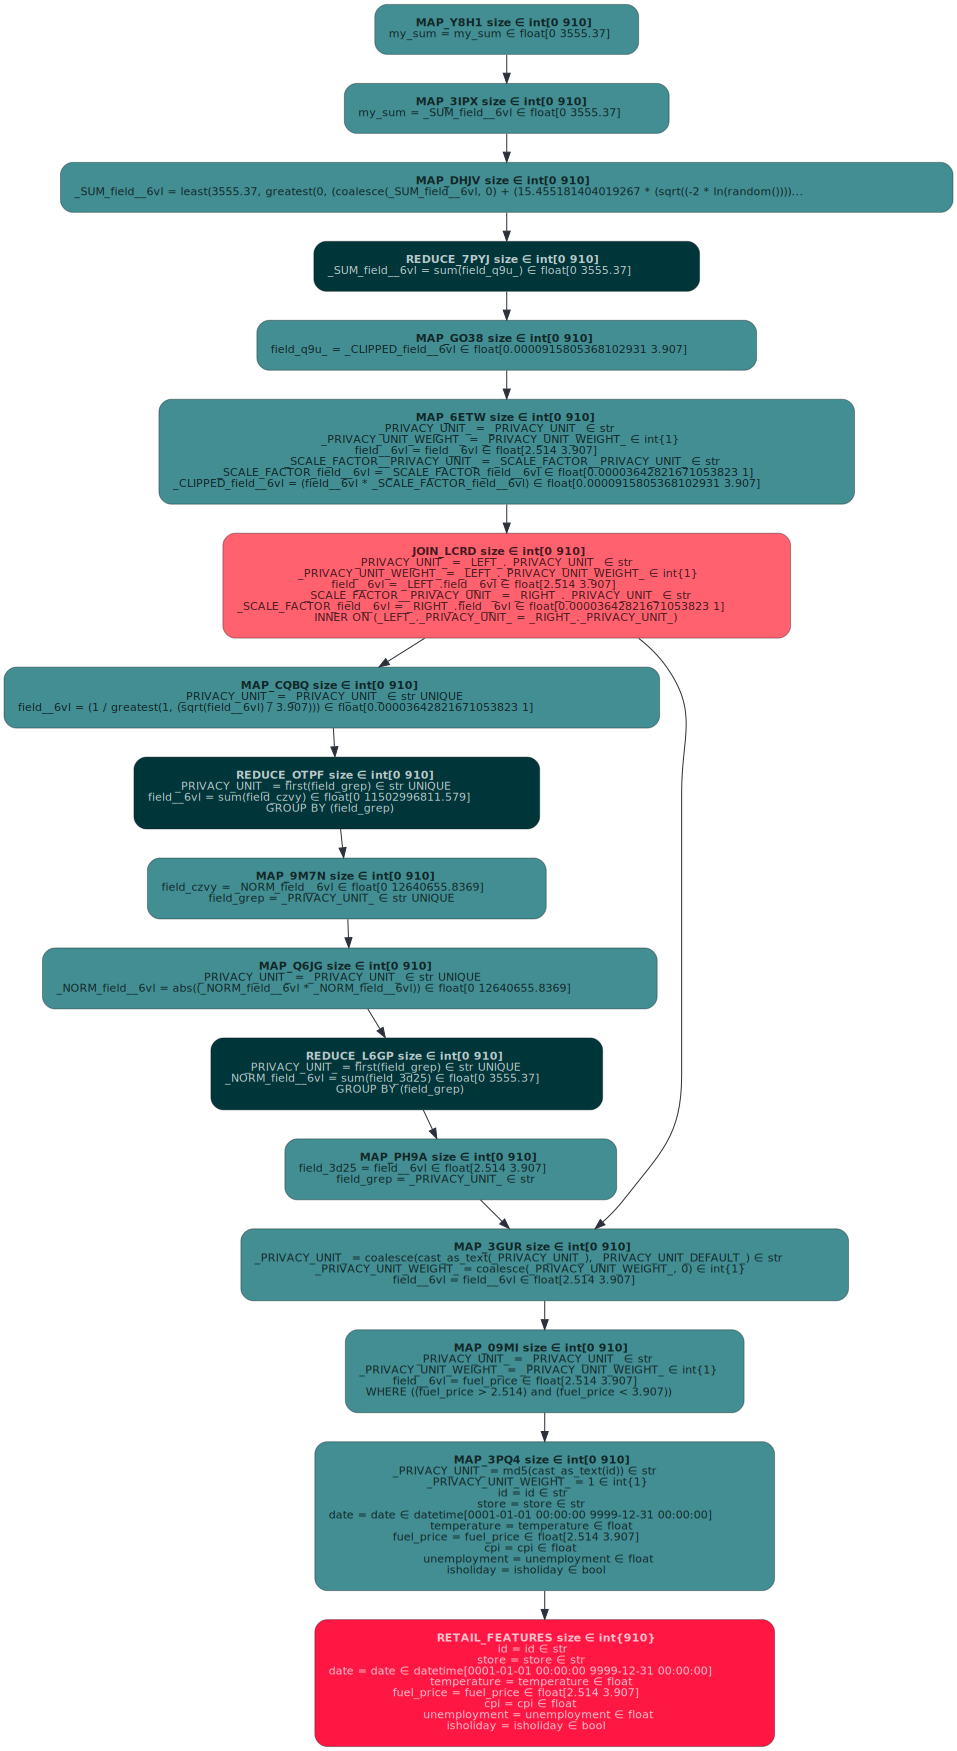

In [19]:
display(Source(dp_relation.dot()))

In [20]:
dp_query = dp_relation.render()
display(dp_query)

"WITH map_3pq4 (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT MD5(CAST(id AS TEXT)) AS _PRIVACY_UNIT_, 1 AS _PRIVACY_UNIT_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features), map_09mi (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field__6vl) AS (SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, fuel_price AS field__6vl FROM map_3pq4 WHERE ((fuel_price) > (2.514)) AND ((fuel_price) < (3.907))), map_3gur (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field__6vl) AS (SELECT COALESCE(CAST(_PRIVACY_UNIT_ AS TEXT), '_PRIVACY_UNIT_DEFAULT_') AS _PRIVACY_UNIT_, COALESCE(_PRIVACY_UNIT_WEIGHT_, 0) AS _PRIVACY_UNIT_WEIGHT_, field__6vl AS field__6vl FROM map_09mi), map_ph9a (field_3d25, field_grep) AS (SELECT field__6vl AS field_3d25, _PRIVACY_UNIT_ AS field_gre

In [21]:
import pandas as pd
true_res = pd.read_sql(query, database.engine())
dp_res = pd.read_sql(dp_query, database.engine())

print(f"Initial query: {true_res.iloc[0].iloc[0]}")
print("DP query:     ", dp_res["my_sum"][0])

Initial query: 2939.4329999999995
DP query:      2940.775245103876


In [22]:
pd.read_sql(query, database.engine())

,my_sum
0,2939.433


In [23]:
pd.read_sql(dp_query, database.engine())

,my_sum
0,2931.895326
